### Load libraries & config

In [1]:
from datetime import date, datetime
import girder_client as gc
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import quote
import random
import re
import string
import tzlocal
from urllib.request import urlopen

with open("config.json", "r") as fp:
    config=json.load(fp)

### Connect to Girder

In [2]:
girder_connection = gc.GirderClient(
    apiUrl="{}/api/v1/".format(
        config["girder-production"]["host"]
    )
)
girder_connection.authenticate(
    username=config["girder-production"]["user"],
    password=config["girder-production"]["password"]
)

In [3]:
ux_questions = {
    q["_id"]: q for q in [
        girder_connection.get(
            question['@id']
        ) for question in 
        girder_connection.getFolder(
            '5c41fb7545e8fc4a94c6ec90'
        )['meta']['screens']
    ]
}
questions = {
    ux_questions[q]['meta']['text']: {
        i: ux_questions[
            q
        ]['meta']['survey']['options'][
            i
        ]['text'] for i in range(
            len(
                ux_questions[q]['meta']['survey']['options']))
    } for q in ux_questions
}
del ux_questions
response_folders = []
for user in girder_connection.get(
    "user"
):
    if user["_id"] != "5b4ca32338488311497dc9bc":
        rf = girder_connection.get(
            "folder?parentType=user&parentId={}&name=Responses".format(
                user["_id"]
            )
        )
        response_folders = [*response_folders, *rf]
inner_response_folders = []
for f in response_folders:
    rf = girder_connection.get(
        "folder?parentType=folder&parentId={}".format(
            f["_id"]
        )
    )
    inner_response_folders = [*inner_response_folders, *rf]
ux_items = []
for f in inner_response_folders:
    rf = girder_connection.get(
        "item?folderId={}".format(
            f["_id"]
        )
    )
    for item in rf:
        if 'meta' in item and 'activity' in item['meta'] and item['meta']['activity']['@id'] == 'folder/5c41fb7545e8fc4a94c6ec90':
            ux_items.append(item)
del response_folders, inner_response_folders
user_responses = {}
for item in ux_items:
    user_responses[item['_id']] = []
    for res in item['meta']['responses']:
        if res and 'data' in res:
            user_responses[item['_id']].append({
                "question": res['text'],
                "response": res['data']['survey'] if 'type' in res['data'] and res['data']['type']=='slider' else res['data']['survey'][0] if type(res['data']['survey'])==list else res['data']['survey']
            })
responses = [user_responses[k] for k in user_responses if len(user_responses[k])]
del user_responses
plot_data = {}
for response in responses:
    for q in response:
        if q["question"] in plot_data:
            plot_data[q["question"]].append(q["response"])
        else:
            plot_data[q["question"]] = [q["response"]]

<Figure size 432x288 with 0 Axes>

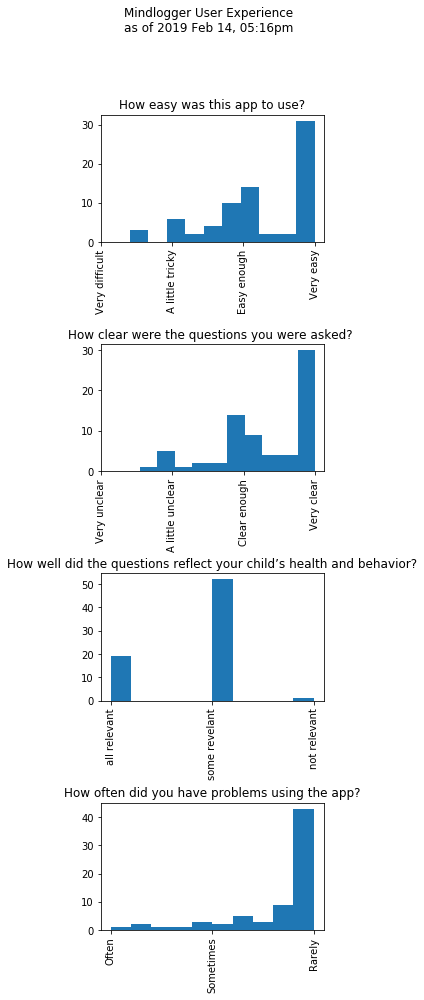

In [4]:
plt.figure()
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(4,15))
for i, question in enumerate(plot_data):
    axes[i].hist(plot_data[question])
    axes[i].set_title(question)
    if min(plot_data[question]) >= 1:
        axes[i].set_xticks(np.arange(1, len(questions[question]) + 1))
    else:
        axes[i].set_xticks(np.arange(0, len(questions[question])))
    axes[i].set_xticklabels([questions[question][k] for k in questions[question]] if question != "How well did the questions reflect your child’s health and behavior?" else ["all relevant", "some revelant", "not relevant"])
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)
fig.subplots_adjust(hspace=0.8)
fig.suptitle(
    "Mindlogger User Experience\nas of {}".format(
        datetime.now().strftime("%Y %b %d, %I:%M%P")
    )
)
plt.savefig(
    "reports/ux-{}.png".format(
        datetime.now().strftime("%Y-%m-%d-%H-%M")
    ),
    dpi=150,
    bbox_inches='tight'
)